In [1]:
import cv2
import os
import matplotlib.pyplot as plt
from copy import deepcopy
from normalization.slant_correction import correct_slant, slant_angle
from normalization.slope_correction import correct_line_inclination

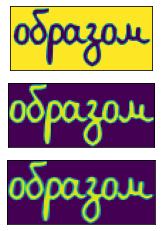

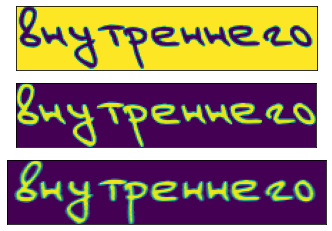

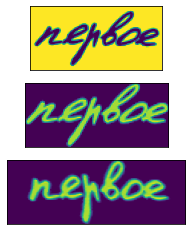

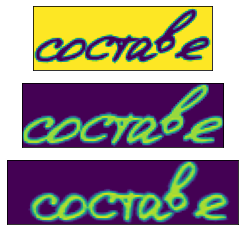

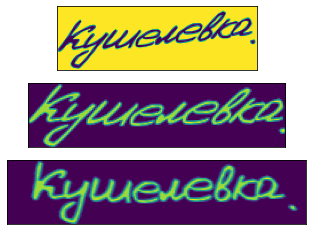

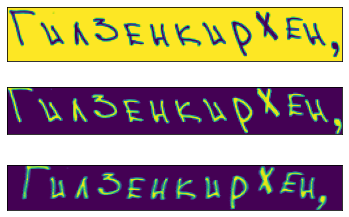

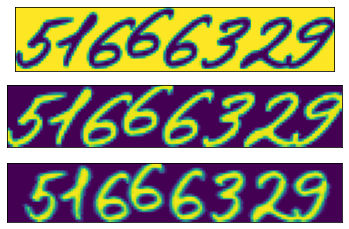

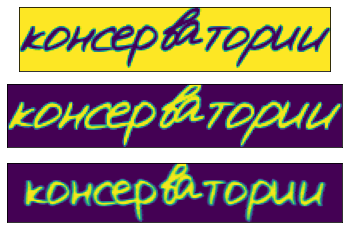

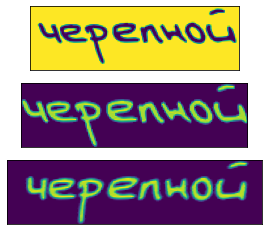

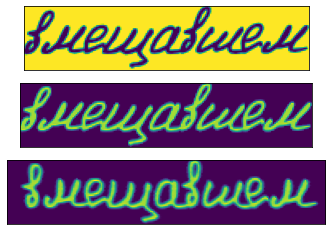

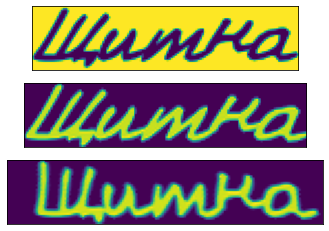

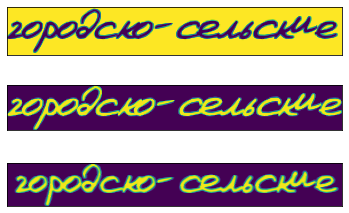

In [2]:
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False


words_dir = "../data/words"

for file_name in os.listdir(words_dir):
    if file_name.startswith("."):
        continue
    line_img = cv2.imread(os.path.join(words_dir, file_name), cv2.IMREAD_GRAYSCALE)
    horizontal_line_img = correct_line_inclination(255-line_img)
    line_img_no_slant, angle, inc_positions = correct_slant(255-horizontal_line_img)
    if abs(slant_angle(line_img_no_slant)) > 0.02:
        line_img_no_slant, angle_2, inc_positions_2 = correct_slant(255-line_img_no_slant)
        inc_positions = inc_positions + inc_positions_2
    fig, axes = plt.subplots(3, 1)
    axes[0].imshow(line_img)
    axes[1].imshow(horizontal_line_img)
    axes[2].imshow(line_img_no_slant)

In [3]:
import torch
from doctr.models import detection_predictor

text_detector = detection_predictor(arch="db_resnet50", pretrained=False).eval()
checkpoint = torch.load("../saved_models/db_resnet50_all_data.pt", map_location='cpu')
text_detector.model.load_state_dict(checkpoint)
text_detector.eval()
print()

/Users/anastasiabogatenkova/miniconda3/envs/doc/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/var/folders/bf/k2xflb9546q_31b80ff0bqk00000gn/T/ipykernel_38017/967444511.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(3, 1)


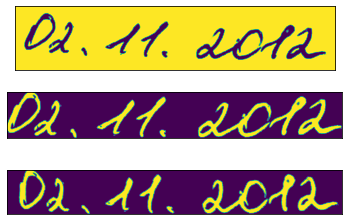

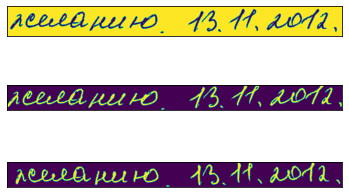

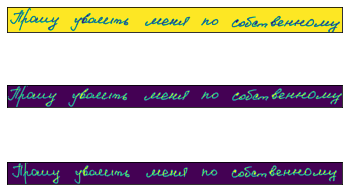

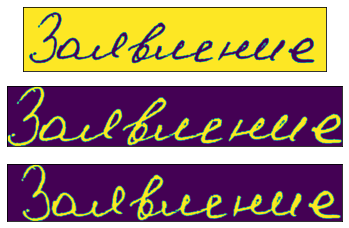

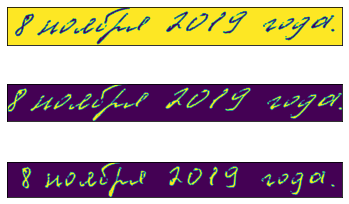

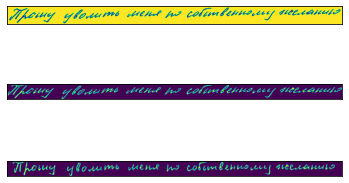

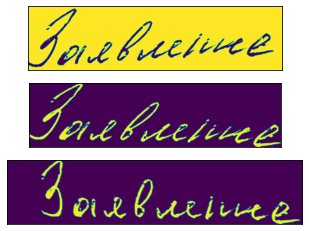

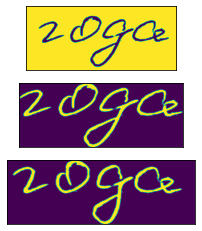

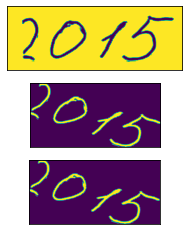

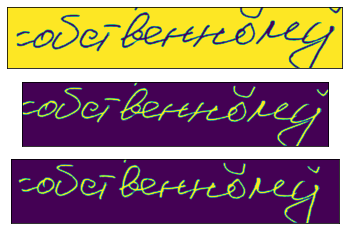

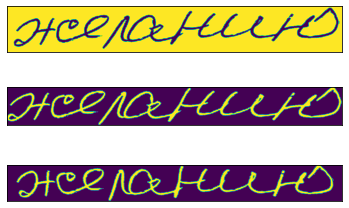

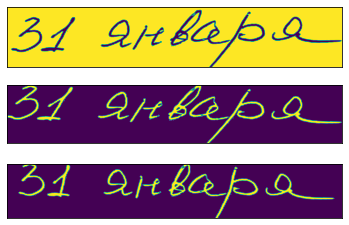

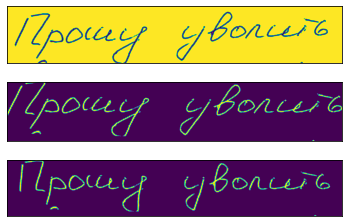

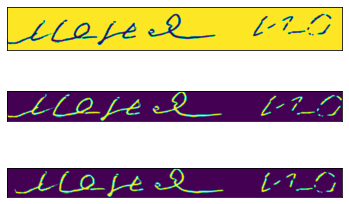

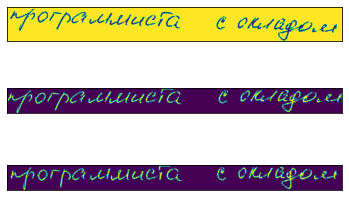

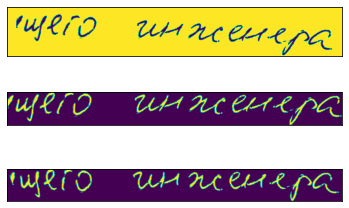

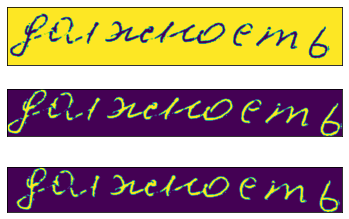

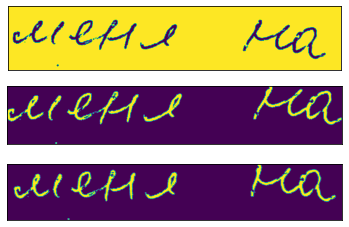

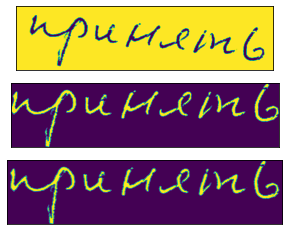

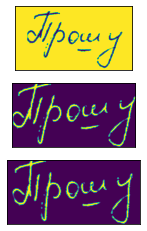

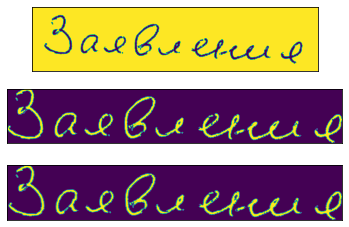

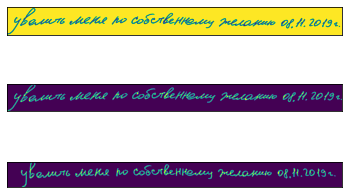

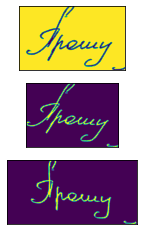

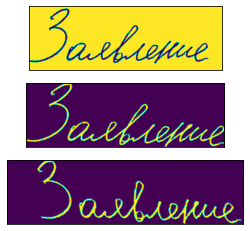

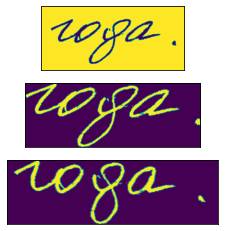

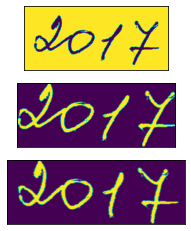

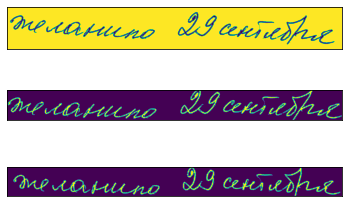

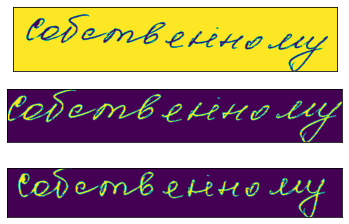

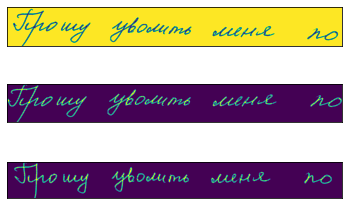

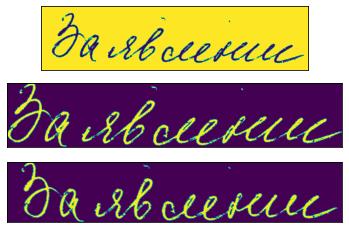

In [4]:
from lines_segmentation.binarization import binarize
from lines_segmentation.lines_seg_cluster import find_lines_bboxes

data_dir = "../data/good_data"
img_num = 0
for file_name in os.listdir(data_dir):
    img = cv2.imread(os.path.join(data_dir, file_name))
    if img is None:
        continue
    h, w, _ = img.shape
    preds = text_detector([img])
    boxes = [(int(pred[0] * w), int(pred[1] * h), int(pred[2] * w), int(pred[3] * h)) for pred in preds[0]]
    line_boxes = find_lines_bboxes(boxes)

    img = binarize(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    for line_box in line_boxes:
        x1, y1, x2, y2 = line_box
        line_img = deepcopy(img[y1:y2, x1:x2])
        horizontal_line_img = correct_line_inclination(255-line_img)
        line_img_no_slant, angle, inc_positions = correct_slant(255-horizontal_line_img)
        if abs(slant_angle(line_img_no_slant)) > 0.02:
            line_img_no_slant, angle_2, inc_positions_2 = correct_slant(255-line_img_no_slant)
            inc_positions = inc_positions + inc_positions_2
        fig, axes = plt.subplots(3, 1)
        axes[0].imshow(line_img)
        axes[1].imshow(horizontal_line_img)
        axes[2].imshow(line_img_no_slant)

    img_num += 1
    if img_num > 5:
        break